In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import os
import random
import platform
import warnings

import tensorflow as tf

from PIL import Image

### data load

In [2]:
mnist = tf.keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

### 이미지 scailing

In [3]:
train_X = train_images/255.
test_X = test_images/255.

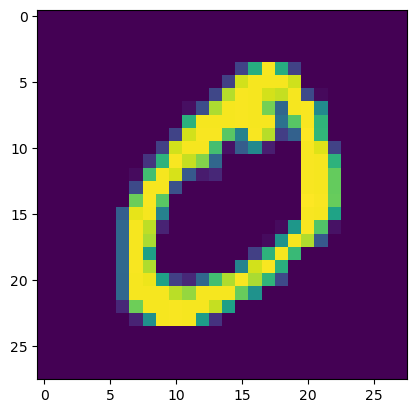

In [5]:
plt.imshow(train_X[1])

### label one-hot encoding

In [4]:
def _onehot(labels):
    onehot = np.zeros((len(labels), len(labels)), dtype='uint8')
    onehot[np.arange(len(labels)), labels] = 1

    return onehot

train_y = _onehot(train_labels)
test_y = _onehot(test_labels)

In [7]:
train_y[1]

array([1, 0, 0, ..., 0, 0, 0], dtype=uint8)

# MLP 구현

### sigmoid

In [8]:
# sigmoid function
def sigmoid(x):
    return 1 / (1+np.exp(-x))

# sigmoid 미분
def sigmoid_prime(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

### sigmoid layer 구현

In [10]:
class Sigmoid():
    def __init__(self):
        self.out = None
    
    def forward(self, x):
        # 순전파시 결과물을 attribute로 저장 및 리턴
        self.out = sigmoid(x)
        return self.out
    
    def backward(self, dout):
        # 역전파시 그래디언트 값을 리턴
        dx = dout * (1.0 - self.out) * self.out
        return dx

In [13]:
# 시그모이드 레이어의 순전파/역전파가 잘 작동하는지 테스트
# 임의의 사이즈에 대해 모두 동일한 크기의 결과가 출력되어야 하며, 각각 단순하게 시그모이드 함수를 적용한 값과 도함수를 적용한 값이 된다면 성공

x = np.random.randn(5, 2)
print('x =\n', x)

sigmoid_layer = Sigmoid()
print('\nsigmoid_layer.forward(x) =\n', sigmoid_layer.forward(x))
print('\nsigmoid_layer.backward(1) =\n', sigmoid_layer.backward(1)) # 최종 출력물의 미분값이 1일 경우 역전파의 결과

x =
 [[ 0.33994424  0.73903127]
 [-1.49076399  0.8070138 ]
 [-0.52041393  0.86163554]
 [-1.29583146 -0.2225015 ]
 [-0.18043494 -1.39695172]]

sigmoid_layer.forward(x) =
 [[0.58417698 0.67678398]
 [0.18380708 0.6914728 ]
 [0.37275545 0.70300225]
 [0.21486741 0.44460298]
 [0.45501325 0.19830027]]

sigmoid_layer.backward(1) =
 [[0.24291424 0.21874742]
 [0.15002204 0.21333817]
 [0.23380882 0.20879009]
 [0.16869941 0.24693117]
 [0.24797619 0.15897728]]


### FC Layer

In [14]:
class FCLayer():
    def __init__(self, input_size, output_size, weight_init_std=0.01):
        self.W = np.random.randn(input_size, output_size)
        self.b = np.random.randn(output_size)

        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b

        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        return dx

In [15]:
# FCLayer 레이어가 임의의 입출력 데이터에 대해 잘 작동하는지 테스트

x = np.random.randn(5, 2)
y = np.random.randn(5, 3)
print('x =\n', x)

fc_layer = FCLayer(2, 3)
print('\nfc_layer.forward(x) =\n', fc_layer.forward(x))
print('\nfc_layer.backward(y) =\n', fc_layer.backward(y))

x =
 [[ 0.1341428   0.50698011]
 [-0.09124876  1.01298656]
 [-1.20229058 -1.95331856]
 [-0.10288817 -0.61541472]
 [ 1.41882148  0.50177454]]

fc_layer.forward(x) =
 [[-1.68152948 -2.66681342 -0.66095653]
 [-3.30449187 -2.66939375 -0.68016535]
 [ 0.80538729 -2.02223888 -3.02854982]
 [ 0.28098274 -2.46958891 -1.36401437]
 [ 1.18435745 -3.0000016   0.63671131]]

fc_layer.backward(y) =
 [[ 0.60545793 -0.87614727]
 [ 1.13858277 -0.13627992]
 [ 4.99266136 -2.44755773]
 [-0.99435403  1.41079113]
 [-2.68662646  2.8552916 ]]


# Loss Function 구현

### MSE

In [16]:
class MSELoss():
    '''Mean Squared Error Loss'''
    def __init__(self):
        self.loss = None    # 손실 함수 값. 역전파 계산을 위해 인스턴스 내에 저장됨
        self.y = None       # 추론값 (y)
        self.t = None       # 실제값 (target)

    def forward(self, y, t):
        '''Forward Propagation of Mean Squared Error Loss'''
        # L = 1/N * sum((y - t)^2)
        self.y = y
        self.t = t
        self.loss = np.mean((t - y) ** 2)
        return self.loss

    def backward(self, dout=1):
        '''Backward Propagation (Backpropagation) of Mean Squared Error Loss'''
        # dL/dy = 2(y - t) / N  ->  dy = 2(y - t) / N
        dx = dout * (self.y - self.t) * 2 / self.t.shape[0]
        return dx

### CrossEntropy

In [17]:
class CrossEntropyLoss():
    '''교차 엔트로피(Cross Entropy) 레이어'''
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None

    def forward(self, y, t):
        '''교차 엔트로피 레이어의 순방향 전파'''
        # L = -1/N * sum(t * log(y) + (1 - t) * log(1 - y))
        self.y = y
        self.t = t
        self.loss = - np.sum(t * np.log(y + 1e-7) + (1 - t) * np.log(1 - y + 1e-7)) / len(y)
        return self.loss

    def backward(self, dout=1):
        '''교차 엔트로피 레이어의 역방향 전파'''
        # dL/dy = -t/y + (1 - t)/(1 - y)  ->  dy = (-t/y + (1 - t)/(1 - y))
        dx =  dout * (self.y - self.t) / (self.t.shape[0] * (1-self.y) * self.y + 1e-7)
        return dx

### MLP 구현

In [18]:
class MLP():
    '''다층 퍼셉트론(Multi Layer Perceptron, MLP) 모델'''
    def __init__(self, input_size, hidden_size_list, output_size, loss_type='MSE'):
        '''신경망의 구조와 손실 함수 정의
        input_size: 입력 데이터의 차원 수
        hidden_size_list: 은닉층 차원 수의 리스트 (e.g. [100, 100, 100])
        output_size: 출력 데이터의 차원 수
        loss_type: 손실 함수의 종류 ('MSE' or 'CrossEntropy')
        '''

        self.input_size = input_size
        self.hidden_size_list = hidden_size_list
        self.output_size = output_size
        self.hidden_layer_num = len(hidden_size_list)
        self.loss_type = loss_type

        ### 레이어 쌓기 : FCLayer -> Sigmoid -> ... -> FCLayer -> Sigmoid
        # 입력층
        self.layers = [
            FCLayer(input_size, hidden_size_list[0]),
            Sigmoid()
        ]
        # 은닉층
        for idx in range(1, self.hidden_layer_num):
            self.layers.append(FCLayer(hidden_size_list[idx-1], hidden_size_list[idx]))
            self.layers.append(Sigmoid())
        # 출력층
        self.layers.append(FCLayer(hidden_size_list[-1], output_size))
        self.layers.append(Sigmoid())

        # 인자로 받은 `loss_type`에 맞게 손실 함수 레이어 정하기
        if self.loss_type == 'MSE':
            self.loss_layer = MSELoss()
        elif self.loss_type == 'CrossEntropy':
            self.loss_layer = CrossEntropyLoss()
        else:
            self.loss_layer = None


        self.loss = None

    def predict(self, x):
        '''입력값을 받았을 때 순방향 전파를 통한 출력물 산출(예측)'''
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def forward(self, x, t):
        '''MLP 모델의 순방향 전파'''
        y = self.predict(x)
        self.loss = self.loss_layer.forward(y, t)
        return self.loss

    def backward(self, dout=1):
        '''MLP 모델의 역방향 전파'''
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

In [19]:
# 임의의 입출력 데이터와 하이퍼파라미터에 대해 MLP 모델이 에러 없이 작동하는지 테스트

x = np.random.randn(5, 2)
y = np.random.randn(5, 1)
print('x =\n', x)

mlp = MLP(input_size=2, hidden_size_list=[10, 5], output_size=1, loss_type='MSE')
print('\nmlp.predict(x) =\n', mlp.predict(x))
print('\nmlp.forward(x, y) =\n', mlp.forward(x, y))
print('\nmlp.backward() =\n', mlp.backward())

x =
 [[-1.68969121  0.13537494]
 [ 0.56437682  0.71196519]
 [ 1.06277838 -0.26555085]
 [ 0.73983243  0.1949527 ]
 [-0.2899809  -0.47756757]]

mlp.predict(x) =
 [[0.22589135]
 [0.2180116 ]
 [0.22122904]
 [0.2196382 ]
 [0.23448836]]

mlp.forward(x, y) =
 0.8785953306251664

mlp.backward() =
 [[ 0.00086094 -0.00166005]
 [ 0.00460587  0.00191726]
 [-0.00151301 -0.00236224]
 [ 0.00404507  0.00336504]
 [ 0.00237073  0.00281788]]


# 모델 학습

### accuracy 함수 정의

In [20]:
# 임의의 입출력 데이터와 하이퍼파라미터에 대해 MLP 모델이 에러 없이 작동하는지 테스트

x = np.random.randn(5, 2)
y = np.random.randn(5, 1)
print('x =\n', x)

mlp = MLP(input_size=2, hidden_size_list=[10, 5], output_size=1, loss_type='MSE')
print('\nmlp.predict(x) =\n', mlp.predict(x))
print('\nmlp.forward(x, y) =\n', mlp.forward(x, y))
print('\nmlp.backward() =\n', mlp.backward())

x =
 [[ 1.0839564   1.50019329]
 [ 0.16281826 -0.04426101]
 [-0.08312976  0.23833026]
 [-0.31740008  1.52891704]
 [ 0.9788983   0.06602767]]

mlp.predict(x) =
 [[0.3081354 ]
 [0.31333168]
 [0.29265639]
 [0.24760672]
 [0.33453433]]

mlp.forward(x, y) =
 0.9384739103189131

mlp.backward() =
 [[ 1.62338350e-04 -8.73421351e-05]
 [ 2.93543181e-02 -2.66775515e-02]
 [-2.83359359e-04  2.24954044e-04]
 [-1.60955765e-02  7.22871721e-03]
 [ 1.77820017e-03 -1.86034763e-03]]


### 하이퍼파라미터 설정

In [21]:
# 네트워크 구조를 정하기 위한 하이퍼파라미터 (784 -> 64 -> 16 -> 10)
n_input = 784
n_hidden = (64,16,)
n_output = 10

# 학습에 필요한 하이퍼파라미터
batch_size = 128
n_epochs = 30
print_every = 1
learning_rate_mse = 3
learning_rate_ce = 0.5

### 모델 생성

In [22]:
# MSE 손실 함수를 사용하는 MLP 모델
mlp_mse = MLP(n_input, n_hidden, n_output, loss_type='MSE')

# Cross Entropy 손실 함수를 사용하는 MLP 모델
mlp_ce = MLP(n_input, n_hidden, n_output, loss_type='CrossEntropy')

### 모델 학습

In [23]:
def training(model, learning_rate, X_train, y_train, X_test, y_test):
    '''모델 학습 함수'''
    training_errors, training_accs = [], [] # 학습 손실 및 정확도
    test_errors, test_accs = [], []         # 테스트 손실 및 정확도

    # 학습 과정 : n_epochs만큼 반복
    for epoch in tqdm(range(n_epochs)):
        # 학습 데이터를 랜덤하게 섞음
        idx = np.random.permutation(X_train.shape[0])
        X_train = X_train[idx]
        y_train = y_train[idx]

        # 미니배치 학습
        for i in range(0, X_train.shape[0], batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            # 순전파
            model.forward(X_batch, y_batch)

            # 역전파
            model.backward()

            # 모델 파라미터 업데이트
            for layer in model.layers:
                if isinstance(layer, FCLayer):
                    layer.W -= learning_rate * layer.dW
                    layer.b -= learning_rate * layer.db

        # 학습 과정 출력 : print_every의 배수에 해당할 때마다 출력
        if (epoch+1) % print_every == 0:
            # 모든 학습 데이터에 대한 손실과 정확도 계산
            model.forward(X_train, y_train)
            training_errors.append(model.loss)
            training_accs.append(accuracy(model.predict(X_train), y_train))

            # 모든 테스트 데이터에 대한 손실과 정확도 계산
            model.forward(X_test, y_test)
            test_errors.append(model.loss)
            test_accs.append(accuracy(model.predict(X_test), y_test))

            # 학습 과정 출력
            print('[Epoch {}/{}] Training Loss = {:.4f} / Training Acc = {:.2f}% /'
                  'Test Loss = {:.4f} / Test Acc = {:.2f}%'.format(
                      epoch+1, n_epochs,
                      training_errors[-1], training_accs[-1]*100,
                      test_errors[-1], test_accs[-1]*100))

    return np.asarray([training_errors, test_errors, training_accs, test_accs])

In [25]:
# MSE 손실 함수를 사용하는 모델 학습
training_result_mse = training(mlp_mse, learning_rate_mse, train_X, train_y, test_X, test_y)

  0%|          | 0/30 [00:00<?, ?it/s]

ValueError: shapes (128,28,28) and (784,64) not aligned: 28 (dim 2) != 784 (dim 0)